# **긴 시계열의 대표 패턴 추출 방법 연구 (1)**

### 창원대 전자공학과 20145234 황주효 (Hwang Ju-hyo, Department of Electronic Engineering, Changwon University)
---

* 짧은 시계열(120초 미만)의 경우, 여러 시계열 유사도 비교 방법을 사용하여 비슷한 패턴을 추출하고 이를 TimeKMeans 클러스터링과 DBA를 이용해 대표 패턴 추출이 가능하다.

* 그러나 실제 제조 데이터를 보면 자주 관측할 수 있는 패턴이 120초 이상인 경우가 많다. 이를 위의 방법으로 그대로 시행하면 시간이 매우 오래 걸리고, 심지어 새로운 데이터가 생길때마다 모든 과정을 새로 시행해야한다. 더군다나 시간이 자면 데이터가 많이 쌓일텐데 이를 모두 클러스터링하기에는 시간 자원이 부족하다.

* 따라서 이를 해결하기 위해 우리는 시계열의 차원 축소를 행해야하고 이를 AutoEncoder를 이용해 수행해본다.

과정은 다음과 같다.
1. 데이터 관찰 및 STL 사용
2. AutoEncoder 훈련
3. Encoder의 출력으로 TimeKMeans 클러스터링 및 대표패턴 추출
4. 상관계수 도출

## **1. 데이터 관찰 및 STL 사용**
---

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

con = []
con.append(pd.read_csv('humi.csv'))
con.append(pd.read_csv('main_powe.csv'))
con.append(pd.read_csv('main_spin.csv'))
con.append(pd.read_csv('pres.csv'))
con.append(pd.read_csv('temp.csv'))
con.append(pd.read_csv('vibr.csv'))

for i in range(0, 6):
    date = datetime.strptime(con[i]['data_date'][0], '%Y-%m-%d %H:%M:%S.%f').strftime('%m/%d/%Y')
    date = pd.DataFrame(con[i]['data_date'])
    con[i]['date'] = date.applymap(str).applymap(lambda s: '{}-{}-{} {}:{}:{}'.format(
        s[0:4], s[5:7], s[8:10],s[11:13],s[14:16],s[17:19]))
    con[i].index = pd.to_datetime(con[i]['date'])
    con[i] = con[i].drop(columns = ['data_date', 'date'])

con[0].columns = ['humi']
con[1].columns = ['main_powe']
con[2].columns = ['main_spin']
con[3].columns = ['pres']
con[4].columns = ['temp']
con[5].columns = ['vibr']

data = con[0].join(con[i] for i in [1,2,3,4,5])

import pickle

with open("data.pickle","wb") as fw:
    pickle.dump(data, fw)

In [3]:
data

humi  main_powe  main_spin   pres   temp  vibr
date                                                                
2020-09-01 10:39:50  61.24      371.3         13   0.00  21.90   0.0
2020-09-01 10:39:51  61.24      371.8          7   0.00  26.12   0.0
2020-09-01 10:39:52  61.24      372.2          0   0.00  25.98   0.0
2020-09-01 10:39:53  61.23      372.7         12   0.00  26.48   0.0
2020-09-01 10:39:54  61.24      371.0          4   0.00  26.36   0.0
...                    ...        ...        ...    ...    ...   ...
2020-09-30 01:22:50  44.14     3167.3         18  43.78  33.59   0.0
2020-09-30 01:22:51  44.12     3164.9          7  43.14  33.49   0.0
2020-09-30 01:22:52  44.10     3157.9          0  43.57  33.58   0.0
2020-09-30 01:22:53  44.11     3172.6          9  43.35  33.49   0.0
2020-09-30 01:22:54  44.13     3161.8         21  43.76  33.57   0.0

[2359540 rows x 6 columns]

* 2020-09-01 ~ 2020-09-30 동안의 습도, 메인 전력, 스핀들, 압력, 온도, 진동 데이터

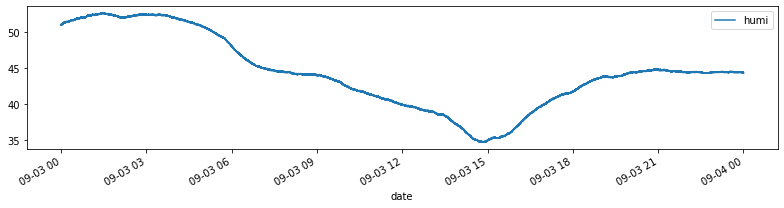

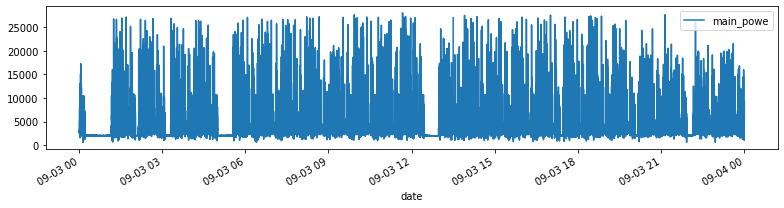

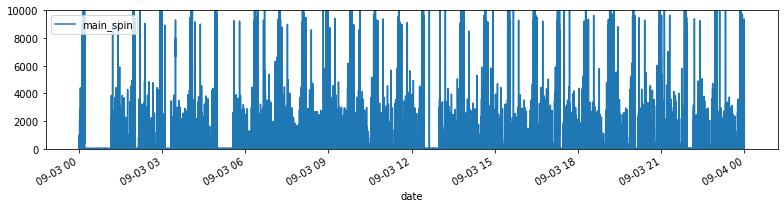

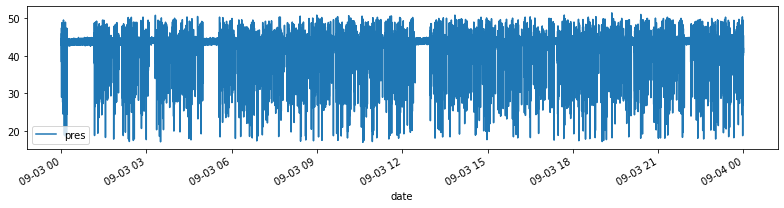

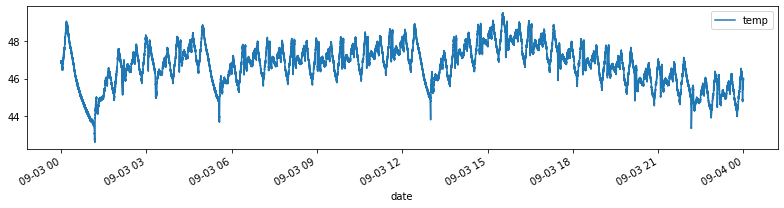

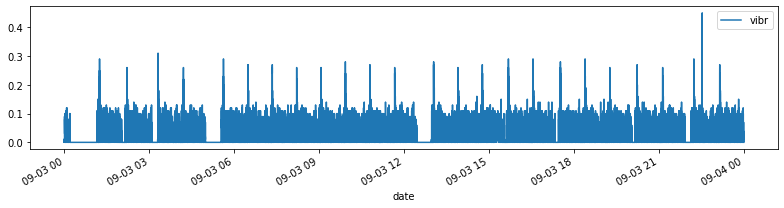

In [4]:
columns = data.columns

for i in range(len(columns)):
    plt.figure()
    if i == 2:
        plt.ylim(0, 10000)
        data[columns[i]]['2020-09-03'].plot(figsize = (11, 3), label = columns[i])
    else : 
        data[columns[i]]['2020-09-03'].plot(figsize = (11, 3), label = columns[i])
    plt.legend()
    plt.tight_layout()
    plt.show()

* 습도는 공정과 큰 관계가 없어보인다.
* 그 외 나머지 특성들에서 계절성이 관측된다.

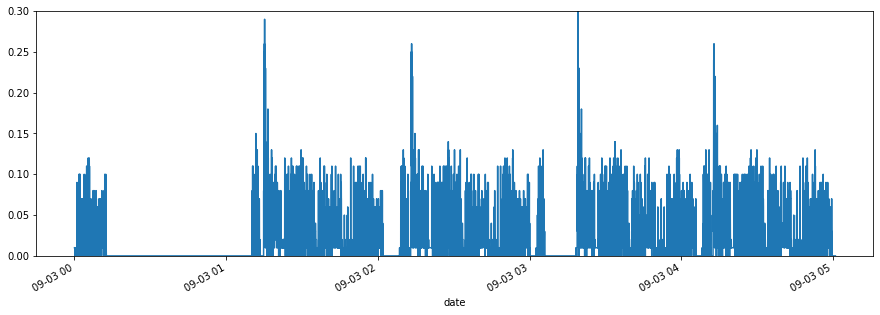

In [5]:
plt.figure()
plt.ylim(0, 0.3)
data[columns[5]]['2020-09-03 00:00':'2020-09-03 05:00'].plot(figsize = (15, 5), label = columns[5])
plt.show()

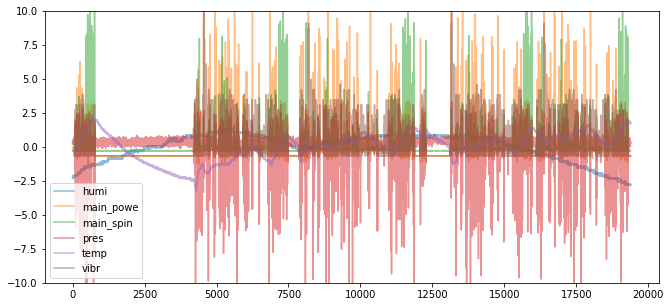

In [6]:
from sklearn.preprocessing import StandardScaler

tmp = data['2020-09-03 00:00':'2020-09-03 05:00']
scaler = StandardScaler()
tmp = pd.DataFrame(scaler.fit_transform(tmp), columns = columns)
tmp.plot(alpha = 0.5, figsize = (11, 5))
plt.ylim(-10, 10)
plt.show()

* 일요일에는 장비를 운용하지 않아 데이터가 없으므로 데이터의 연속성을 위해 기간을 각 주로 나누어 관리한다.
* 소수의 NaN이 관측되나 선형으로 보간한다.

In [7]:
X = []
X.append(data.loc['2020-09-02':'2020-09-06'].iloc[1:, :])
X.append(data.loc['2020-09-07':'2020-09-13'].iloc[13:, :])
X.append(data.loc['2020-09-14':'2020-09-20'].iloc[1:, :])
X.append(data.loc['2020-09-21':'2020-09-27'].iloc[1:, :])
X.append(data.loc['2020-09-28':'2020-09-30 02:00'].iloc[1:, :])

In [8]:
with open("data_week.pickle","wb") as fw:
    pickle.dump(X, fw)

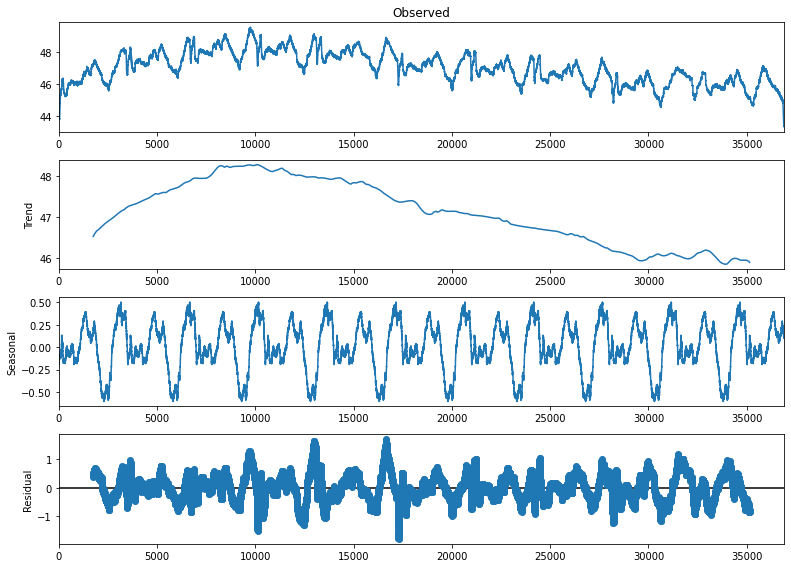

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = X[0].interpolate()['temp'].reset_index(drop = True)[136733:173627].values
result = seasonal_decompose(series, model='additive', period=3500)
plt.rc("figure", figsize=(11,8))
result.plot()
plt.show()

* 온도 특성에 시계열 분해를 적용해본 결과(하나의 패턴이 대략 3500초) 어느 정도 설명력이 있는 계절성을 확인할 수 있다.
* 이제 Robust 스케일러와 필터를 적용해 진동패턴의 인덱스를 추출한다.

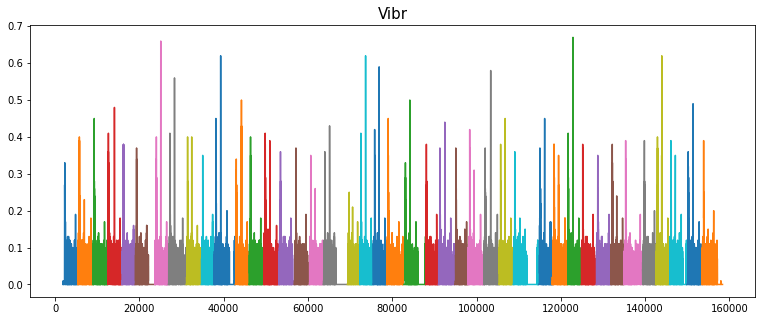

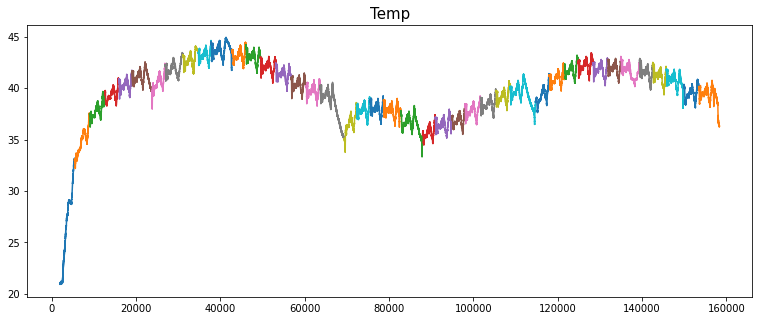

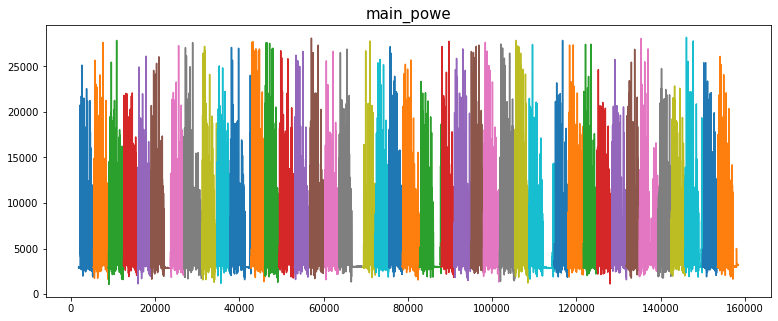

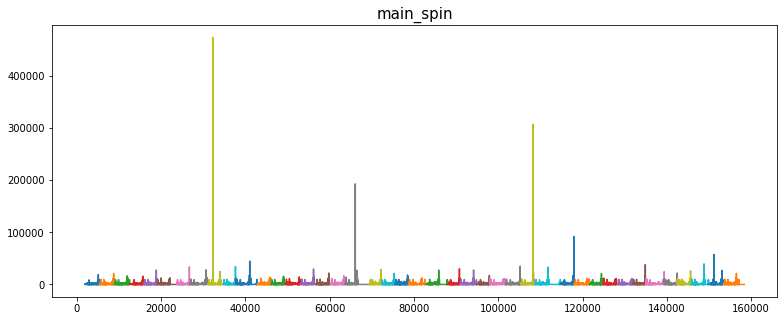

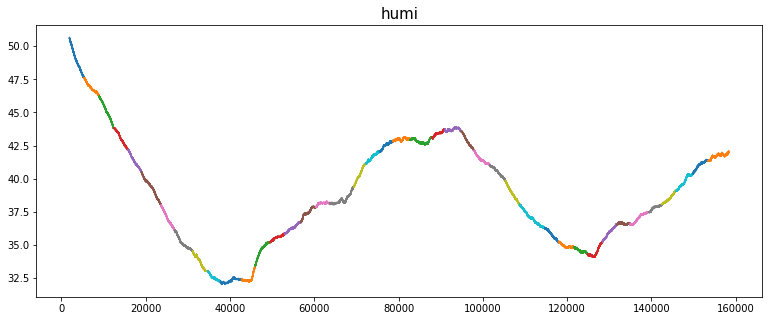

In [10]:
all_extract = []
all_extract_resetindex = []
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

for num in range(0, 5):
    for i in range(5):
        X[i] = X[i].interpolate()

    X_re = X[num].reset_index(drop = True)

    index = X_re[X_re['vibr'] > 0.2].index

    index = pd.DataFrame(index)
    index.columns = ['origin']

    index['start'] = index['origin'] - 500
    index['end'] = index['origin'] + 4400

    rein = []
    
    i = 0
    
    while(i < len(index)-1):
        if index['start'][i+1] - index['start'][i] < 200 :
            i = i+1
            continue
        if index['start'][i+1] - index['start'][i] < 2500 and index['start'][i+1] - index['start'][i] > 500 :
            rein.append(i)
            i = i+2
            continue
        if index['start'][i+1] - index['start'][i] > 1500 :
            rein.append(i)
        i = i+1

    rein.append(len(index)-1)

    index_re = index.loc[rein].reset_index(drop=True)

    new_end = []
    ii = []
    iii = []
    
    dd = pd.DataFrame()
    
    for i in range(len(index_re)):
        if i == len(index_re)-1:
            ii.append(index_re.iloc[i]['end'])
            continue
        o = 1
        
        for j in range(300):
            if X_re.iloc[index_re.iloc[i+1]['origin'] - 100 - j - 50: 
                         index_re.iloc[i+1]['origin'] - 100 - j]['vibr'].max() == 0:    
                ii.append(index_re.iloc[i+1]['origin'] - 100 - j - 50)
                o = o+1
                
        if o == 1:
            ii.append(index_re.iloc[i+1]['origin'] - 500)
            
    ii = np.array(ii)

    weu = []
    
    for i in range(len(ii)-1):
        if ii[i+1] - ii[i] > 1 :
            weu.append(ii[i])
            
    weu.append(index_re.iloc[-1, 2])

    index_re['end'] = weu
    tee= index_re

    extract = []
    for i in range(len(tee)):
        extract.append(X_re.iloc[tee['start'][i] : tee['end'][i]])

    tm = index_re.copy()
    for i in range(1, len(tm)-1):
        tm.iloc[i]['start'] = tm.iloc[i-1]['end']

    extract = []
    tee = tm
    for i in range(len(tee)):
        extract.append(X_re.iloc[tee['start'][i] : tee['end'][i]])

    length = []
    for i in range(len(extract)):
        length.append(len(extract[i]))

    teeee = tee.copy()

    select = []
    select.append([]) # X[0]
    select.append([3, 68, 96, 102,114, 122, 144]) # X[1]
    select.append([13, 20, 30, 35, 51, 96, 112, 127, 138, ]) # X[2]
    select.append([9, 14, 45, 48,62, 64, 67, 70, 77, 85, 88, 96, 99, 112, 115, 122, 124, 127, 131, 138, 145, 156, ]) # X[3]
    select.append([7, 9, 14,17, 25, 28, 34, 38,40, 42, 49, 52]) # X[4]
    st = 0
    
    for i in select[num]:
        teeee.iloc[i-1-st]['end'] = teeee.iloc[i-st]['end']
        teeee = teeee.drop(index = i-st)
        teeee = teeee.reset_index(drop = True)
        st = st+1

    extract = []
    extract_resetindex = []
    
    for i in range(len(teeee)):
        extract.append(X_re.iloc[teeee['start'][i] : teeee['end'][i]])
        extract_resetindex.append(X_re.iloc[teeee['start'][i] : teeee['end'][i]].reset_index(drop = True))
    
    if num == 4:
        for i in range(len(extract)):
            extract[i]['vibr'].plot(figsize = (13, 5))
            plt.title('Vibr', {'fontsize' : 15})
        plt.show()

        for i in range(len(extract)):
            extract[i]['temp'].plot(figsize = (13, 5))
            plt.title('Temp', {'fontsize' : 15})
        plt.show()
        
        for i in range(len(extract)):
            extract[i]['main_powe'].plot(figsize = (13, 5))
            plt.title('main_powe', {'fontsize' : 15})
        plt.show()
        
        for i in range(len(extract)):
            extract[i]['main_spin'].plot(figsize = (13, 5))
            plt.title('main_spin', {'fontsize' : 15})
        plt.show()
        
        for i in range(len(extract)):
            extract[i]['humi'].plot(figsize = (13, 5))
            plt.title('humi', {'fontsize' : 15})
        plt.show()
    
    all_extract.append(extract)
    all_extract_resetindex.append(extract_resetindex)

In [11]:
print(len(all_extract[0]))
print(len(all_extract[1]))
print(len(all_extract[2]))
print(len(all_extract[3]))
print(len(all_extract[4]))

81
138
138
138
42


* 습도는 역시 패턴을 관찰할 수가 없다.

In [12]:
scaler.fit(X[2].interpolate())
X_scaled = []
for i in range(0, 5):
    X_scaled.append(pd.DataFrame(scaler.transform(X[i].interpolate()), columns = X[i].columns))
    
all_extract_scaled = []
for j in range(0, 5):
    tmp = []
    for i in range(len(all_extract_resetindex[j])):
        tmp.append(X_scaled[j].reset_index().loc[all_extract[j][i].index]) # X_scaled -> X
    all_extract_scaled.append(tmp)
    
all_extract_resetindex = all_extract_scaled
all_extract_resetindex_list = np.concatenate([all_extract_resetindex[i] for i in range(0, 5)])

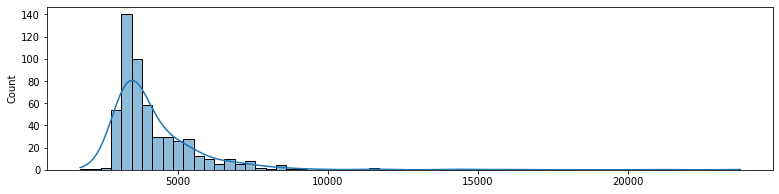

In [13]:
import seaborn as sns

length = []
for i in range(len(all_extract_resetindex_list)):
    length.append(len(all_extract_resetindex_list[i]))
    
plt.figure(figsize = (13, 3))
sns.histplot(length, kde = True)
plt.show()

* 시계열의 평균 길이가 대략 3300이므로 4000 이상, 2500 미만은 이상치로 간주해 제외한다.

In [45]:
normal = []
abnormal = []

def get_numpy_from_nonfixed_2d_array(aa, fixed_length, padding_value=0):
    rows = []
    for a in aa:
        rows.append(np.pad(a, (0, fixed_length), 'constant', constant_values=padding_value)[:fixed_length])
    return np.concatenate(rows, axis=0).reshape(-1, fixed_length)

for x in all_extract_resetindex_list:
    if len(x) > 2500 and len(x) < 4000:
        normal.append(x)
    else : 
        abnormal.append(x)
        
normal = np.array(normal)
abnormal = np.array(abnormal)

normal_concat = {}
columns = ['vibr', 'main_powe', 'main_spin', 'temp', 'pres']

normal_padding = {}

for column in columns:
    normal_concat[column] = []
    normal_padding[column] = np.empty(shape = (1, 4000))
    for x in normal:
        normal_concat[column].append(x[column])
    
    padding_value = [-0.5, -1.21, -0.5, 1.5, 0]
    if column == 'vibr' :
        padding_value = -0.5
        te = get_numpy_from_nonfixed_2d_array(normal_concat[column], fixed_length = 4000, padding_value = padding_value)
    if column == 'main_powe' :
        padding_value = -1.21
        te = get_numpy_from_nonfixed_2d_array(normal_concat[column], fixed_length = 4000, padding_value = padding_value)
    
    if column == 'main_spin' :
        padding_value = -0.5
        te = get_numpy_from_nonfixed_2d_array(normal_concat[column], fixed_length = 4000, padding_value = padding_value)

    if column == 'temp' :
        padding_value = 1.5
        te = get_numpy_from_nonfixed_2d_array(normal_concat[column], fixed_length = 4000, padding_value = padding_value)

    if column == 'pres' :
        padding_value = 0
        te = get_numpy_from_nonfixed_2d_array(normal_concat[column], fixed_length = 4000, padding_value = padding_value)
    normal_padding[column] = np.append(normal_padding[column], te, axis = 0)

In [46]:
normal_padding['vibr'] = normal_padding['vibr'][1:]
normal_padding['temp'] = normal_padding['temp'][1:]
normal_padding['main_spin'] = normal_padding['main_spin'][1:]
normal_padding['main_powe'] = normal_padding['main_powe'][1:]
normal_padding['pres'] = normal_padding['pres'][1:]

<AxesSubplot:>

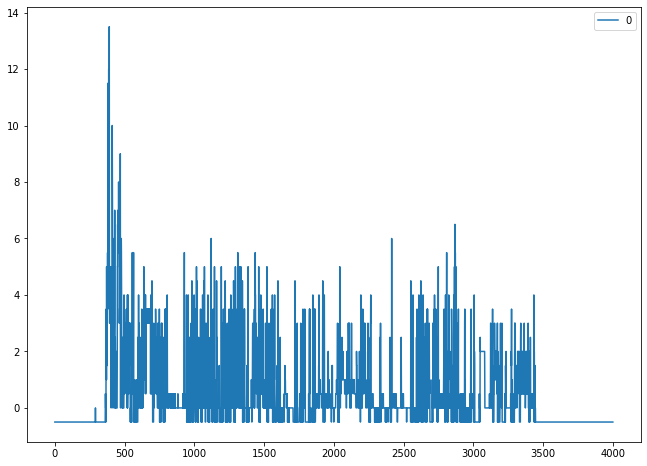

In [47]:
pd.DataFrame(normal_padding['vibr'][0]).plot()

In [48]:
with open("extract_padding.pickle","wb") as fw:
    pickle.dump(normal_padding, fw)